# BC4 

Apex Pattern Deployers

- Marjorie Kinney *m20210647*
- Bruno Mendes *m20210627*
- Lucas Neves *m20211020*
- Farina Pontejos *m20210649*

Business Cases for Data Science

NOVA Information Management School

May 2022

https://github.com/fpontejos/bc4


## Initial Setup

### Imports

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from math import ceil
from datetime import timedelta, datetime
import os
import re
import warnings
import itertools
import collections
#import ta

warnings.filterwarnings('ignore')



In [2]:
from matplotlib.colors import LinearSegmentedColormap


In [3]:
from functools import reduce

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

from sklearn.preprocessing import StandardScaler


from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import SCORERS


In [5]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()


### Variables

In [6]:
COLORS = ['#2ec4b6', '#1e9fb4', '#0f7ab2', '#285892', '#49306b', '#7a3161', '#a13258', '#c63351', '#ea3449']

CAT_COLORS = ['#2EC4B6', '#0E79B2', '#49306B', '#9A325A', '#EA3449']
CONTRAST_COLORS = [COLORS[i] for i in range(len(COLORS)) if (i%2) == 0]

DIV_COLORS = ['#0e79b2', '#4b9ac3', '#84b8d4', '#bcd6e4', '#f4f4f4', '#c6c0d0', '#9b8eac', '#715e8b', '#49306b']

DIV_COL_HALF = ['#f4f4f4', '#bed3da', '#8ab2bf', '#5592a5', '#20718b']

UMP_COLORS = ['#22446D', '#FC9E4F', '#AB2346' ,'#6ABB5D']

DEFAULT_PALETTE = sns.color_palette(COLORS)
CONTRAST_PALETTE = sns.color_palette(CONTRAST_COLORS)
DIVERGENT_PALETTE = sns.color_palette(DIV_COLORS)
DIVHALF_PALETTE = sns.color_palette(DIV_COL_HALF)
CAT_PALETTE = sns.color_palette(CAT_COLORS)
UMP_PALETTE = sns.color_palette(UMP_COLORS)


DIV_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COLORS)
DIV_H_CMAP = LinearSegmentedColormap.from_list("div_colors", DIV_COL_HALF)
CAT_CMAP = LinearSegmentedColormap.from_list("cat_colors", CAT_COLORS)
UMP_CMAP = LinearSegmentedColormap.from_list("ump_colors", UMP_COLORS)


SHOW_PLOTS = True
SAVE_PLOTS = True
RANDOM_STATE = 9

IMG_PATH = '../imgs/'
DATA_IN_PATH = '../../source/data/'
DATA_OUT_PATH = '../../data_out/'


In [7]:
def save_fig(title, fig):
    if SAVE_PLOTS == True:
        fn = IMG_PATH + title.replace(' ','-') + '.png'
        fig.savefig(fn, bbox_inches='tight', transparent=True)
        


### Styles

In [8]:
sns.set(style="white")

sns.set_context("paper")
sns.set_palette(DEFAULT_PALETTE)


plt.rcParams['figure.dpi'] = 128

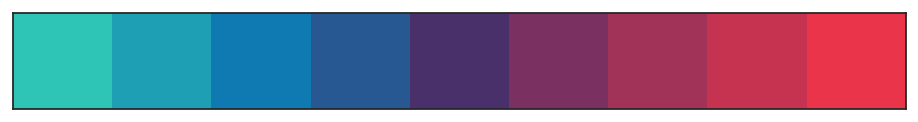

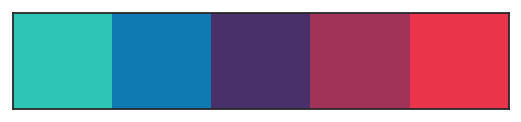

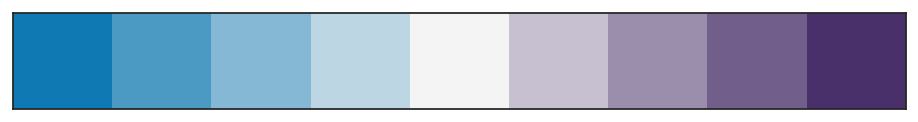

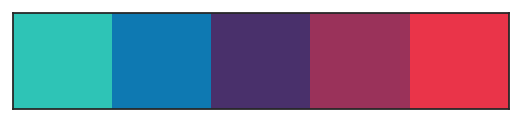

In [9]:
sns.palplot(DEFAULT_PALETTE)
sns.palplot(CONTRAST_PALETTE)
sns.palplot(DIVERGENT_PALETTE)
sns.palplot(CAT_PALETTE)
plt.show()

## Load Data

In [25]:
df_all = pd.read_csv(DATA_OUT_PATH + "merged_data.csv")
df_all.head(3)

,Date,ada_close,ada_high,ada_low,ada_open,ada_volume,atom_close,atom_high,atom_low,atom_open,...,luna1_trend_macd,luna1_volatility_atr,matic_volume_obv,matic_momentum_rsi,matic_trend_macd,matic_volatility_atr,sol_volume_obv,sol_momentum_rsi,sol_trend_macd,sol_volatility_atr
0,2021-01-01,0.175350,0.184246,0.172022,0.181382,1.122218e+09,5.868556,6.506998,5.652401,6.490297,...,0.053993,0.051369,2.036519e+09,47.984858,-0.000144,0.001536,255658268.0,57.385950,-0.050738,0.191277
1,2021-01-02,0.177423,0.184253,0.169233,0.175359,1.408850e+09,5.414613,5.882211,5.319140,5.869282,...,0.053286,0.049277,2.053894e+09,53.344082,-0.000058,0.001609,223987204.0,55.832142,-0.027803,0.198930
2,2021-01-03,0.204995,0.208679,0.173376,0.177382,2.303858e+09,5.813898,5.900645,5.301713,5.416301,...,0.054555,0.049605,2.071803e+09,56.959753,0.000084,0.001614,279060626.0,64.577875,0.019398,0.235608


In [26]:

#removing 2021
df_all=df_all.iloc[365:]

In [27]:
## How much data to use for model selection crossval
TRAIN_SIZE = 90

## How large the timeseriessplit window should be
WINDOW_SIZE = 7

## How many days for cv test
TEST_SIZE = 1

In [28]:
def shift_split_data(df_, target_col, trainsize):
    df = df_.copy()
    df['Date_Y'] = df['Date'].shift(periods=-1)
    df['Y'] = df[target_col].shift(periods=-1)
    df.rename(columns={'Date':'Date_X'}, inplace=True)
    
    ## DF for prediction (only last trainsize days)
    ## Use to predict day after last df Date
    df_forprediction = df.iloc[trainsize:]
    
    ## DF for train + test (without last trainsize days)
    df_tt = df.iloc[:trainsize]
    return df_tt, df_forprediction
    
    

In [29]:
target_col = 'btc_close'

In [30]:
df_tt, df_forprediction = shift_split_data(df_all, target_col, TRAIN_SIZE)

# BTC (BITCOIN)

## Model Selection

In [18]:
#df_tt.head(5)

### Set up pipeline

In [35]:
score_func = 'neg_mean_squared_error'

In [36]:
## Split X and Y

Y = df_tt['Y']

x_cols = [i for i in df_tt.columns.tolist() if i not in ['Date_X', 'Date_Y', 'Y'] ]
X = df_tt[x_cols]

In [43]:
pipe_ada_dt = make_pipeline(StandardScaler(),
                    SelectKBest(f_regression),
                    GradientBoostingRegressor(random_state=RANDOM_STATE))

## Selecting loss and k best
params_dt = {
    'selectkbest__k':[5,10,12,15,16,17,18,19,20,50],
    'gradientboostingregressor__loss':['squared_error', 'absolute_error', 'huber', 'quantile']
}

## Setup TimeSeriesSplit
num_splits = int(len(X)/(WINDOW_SIZE+TEST_SIZE))

tscv = TimeSeriesSplit(n_splits=num_splits, max_train_size=WINDOW_SIZE, test_size=TEST_SIZE)


# Setting up the grid search
gs_dtr = GridSearchCV(pipe_ada_dt, 
                      params_dt, 
                      n_jobs=-1, 
                      cv=tscv,
                      scoring=score_func,
                      refit=True
                     )



In [44]:
# Fit GS to training data
gs_dtr.fit(X, Y)
df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
35,-1.055007e+06,{'gradientboostingregressor__loss': 'quantile'...,1
33,-1.080841e+06,{'gradientboostingregressor__loss': 'quantile'...,2
38,-1.091184e+06,{'gradientboostingregressor__loss': 'quantile'...,3


In [45]:
gs_dtr.best_params_

{'gradientboostingregressor__loss': 'quantile', 'selectkbest__k': 17}

In [52]:
#testing for n-estimators

params_dt = {
    'selectkbest__k':[17],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
10,-1.054999e+06,{'gradientboostingregressor__loss': 'quantile'...,1
18,-1.054999e+06,{'gradientboostingregressor__loss': 'quantile'...,1
17,-1.054999e+06,{'gradientboostingregressor__loss': 'quantile'...,1


In [53]:
gs_dtr.best_params_

{'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__n_estimators': 296,
 'selectkbest__k': 17}

In [56]:
#testing for learning rate 

params_dt = {
    'selectkbest__k':[17],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[296],
    'gradientboostingregressor__learning_rate':[0.09,0.095,0.099,0.1,0.11,0.12,0.13,0.14,0.15,0.2]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
6,-1.052364e+06,{'gradientboostingregressor__learning_rate': 0...,1
7,-1.052491e+06,{'gradientboostingregressor__learning_rate': 0...,2
5,-1.052690e+06,{'gradientboostingregressor__learning_rate': 0...,3


In [57]:
gs_dtr.best_params_

{'gradientboostingregressor__learning_rate': 0.13,
 'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__n_estimators': 296,
 'selectkbest__k': 17}

In [74]:
#testing for max depth

params_dt = {
    'selectkbest__k':[17],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[296],
    'gradientboostingregressor__learning_rate':[0.13],
    'gradientboostingregressor__max_depth':[0.95,0.96,0.97,0.98,0.99,1,1.01,1.02,1.03,1.04,1.05,1.06,1.07,1.2,3]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
5,-1.052364e+06,{'gradientboostingregressor__learning_rate': 0...,1
6,-1.052364e+06,{'gradientboostingregressor__learning_rate': 0...,1
7,-1.052364e+06,{'gradientboostingregressor__learning_rate': 0...,1


In [75]:
gs_dtr.best_params_

{'gradientboostingregressor__learning_rate': 0.13,
 'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__max_depth': 1,
 'gradientboostingregressor__n_estimators': 296,
 'selectkbest__k': 17}

In [77]:
#testing for max features

params_dt = {
    'selectkbest__k':[17],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[296],
    'gradientboostingregressor__learning_rate':[0.13],
    'gradientboostingregressor__max_depth':[1],
    'gradientboostingregressor__max_features':['auto', 'sqrt', 'log2',None]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
0,-1.052364e+06,{'gradientboostingregressor__learning_rate': 0...,1
3,-1.052364e+06,{'gradientboostingregressor__learning_rate': 0...,1
1,-1.163744e+06,{'gradientboostingregressor__learning_rate': 0...,3


In [78]:
gs_dtr.best_params_

{'gradientboostingregressor__learning_rate': 0.13,
 'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__max_depth': 1,
 'gradientboostingregressor__max_features': 'auto',
 'gradientboostingregressor__n_estimators': 296,
 'selectkbest__k': 17}

In [76]:
#other params did not change from default

## FINAL PREDICTION BTC

In [79]:
best_estimator = gs_dtr.best_estimator_
best_estimator.fit(df_forprediction[x_cols][:-1], df_forprediction['Y'][:-1])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=17,
                             score_func=<function f_regression at 0x00000148A650DCA0>)),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.13, loss='quantile',
                                           max_depth=1, max_features='auto',
                                           n_estimators=296, random_state=9))])

In [80]:
## Make prediction for last
best_estimator.predict(df_forprediction[x_cols][-1:])

array([41502.74875534])

In [94]:
april_26_truth= 38117.46
april_26_pred=41502.74875534

mean_absolute_percentage_error([april_26_truth],[april_26_pred])

0.08881202355403534

# ADA-USD CARDANO

In [95]:
target_col = 'ada_close'
df_tt, df_forprediction = shift_split_data(df_all, target_col, TRAIN_SIZE)

score_func = 'neg_mean_squared_error'

Y = df_tt['Y']

x_cols = [i for i in df_tt.columns.tolist() if i not in ['Date_X', 'Date_Y', 'Y'] ]
X = df_tt[x_cols]

pipe_ada_dt = make_pipeline(StandardScaler(),
                    SelectKBest(f_regression),
                    GradientBoostingRegressor(random_state=RANDOM_STATE))

## Selecting loss and k best
params_dt = {
    'selectkbest__k':[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,50],
    'gradientboostingregressor__loss':['squared_error', 'absolute_error', 'huber', 'quantile']
}

## Setup TimeSeriesSplit
num_splits = int(len(X)/(WINDOW_SIZE+TEST_SIZE))

tscv = TimeSeriesSplit(n_splits=num_splits, max_train_size=WINDOW_SIZE, test_size=TEST_SIZE)


# Setting up the grid search
gs_dtr = GridSearchCV(pipe_ada_dt, 
                      params_dt, 
                      n_jobs=-1, 
                      cv=tscv,
                      scoring=score_func,
                      refit=True
                     )

# Fit GS to training data
gs_dtr.fit(X, Y)
df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
56,-0.002525,{'gradientboostingregressor__loss': 'quantile'...,1
61,-0.002548,{'gradientboostingregressor__loss': 'quantile'...,2
59,-0.002563,{'gradientboostingregressor__loss': 'quantile'...,3


In [96]:
gs_dtr.best_params_

{'gradientboostingregressor__loss': 'quantile', 'selectkbest__k': 10}

In [97]:
#testing for n-estimators

params_dt = {
    'selectkbest__k':[10],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[20,50,100,200,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
24,-0.002525,{'gradientboostingregressor__loss': 'quantile'...,1
22,-0.002525,{'gradientboostingregressor__loss': 'quantile'...,1
21,-0.002525,{'gradientboostingregressor__loss': 'quantile'...,1


In [98]:
gs_dtr.best_params_

{'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__n_estimators': 303,
 'selectkbest__k': 10}

In [107]:
#testing for learning rate

params_dt = {
    'selectkbest__k':[10],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[303],
    'gradientboostingregressor__learning_rate':[1.45,1.46,1.47,1.48,1.49,1.5,1.51,1.52,1.53,1.54,1.55]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
8,-0.002218,{'gradientboostingregressor__learning_rate': 1...,1
9,-0.002235,{'gradientboostingregressor__learning_rate': 1...,2
3,-0.002258,{'gradientboostingregressor__learning_rate': 1...,3


In [108]:
gs_dtr.best_params_

{'gradientboostingregressor__learning_rate': 1.53,
 'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__n_estimators': 303,
 'selectkbest__k': 10}

In [109]:

#testing for max depth

params_dt = {
    'selectkbest__k':[10],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[303],
    'gradientboostingregressor__learning_rate':[1.53],
    'gradientboostingregressor__max_depth':[0.95,0.96,0.97,0.98,0.99,1,1.01,1.02,1.03,1.04,1.05,1.06,1.07,1.2,3,4,5]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
8,-0.001997,{'gradientboostingregressor__learning_rate': 1...,1
13,-0.001997,{'gradientboostingregressor__learning_rate': 1...,1
12,-0.001997,{'gradientboostingregressor__learning_rate': 1...,1


In [110]:
gs_dtr.best_params_

{'gradientboostingregressor__learning_rate': 1.53,
 'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__max_depth': 1,
 'gradientboostingregressor__n_estimators': 303,
 'selectkbest__k': 10}

In [115]:

#testing for max features

params_dt = {
    'selectkbest__k':[10],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[303],
    'gradientboostingregressor__learning_rate':[1.53],
    'gradientboostingregressor__max_depth':[1],
    'gradientboostingregressor__max_features':['auto', 'sqrt', 'log2',None]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)



,mean_test_score,params,rank_test_score
0,-0.001997,{'gradientboostingregressor__learning_rate': 1...,1
3,-0.001997,{'gradientboostingregressor__learning_rate': 1...,1
1,-0.003385,{'gradientboostingregressor__learning_rate': 1...,3


In [116]:
gs_dtr.best_params_

{'gradientboostingregressor__learning_rate': 1.53,
 'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__max_depth': 1,
 'gradientboostingregressor__max_features': 'auto',
 'gradientboostingregressor__n_estimators': 303,
 'selectkbest__k': 10}

## FINAL PREDICTION CARDANO ADA-USD

In [117]:
best_estimator = gs_dtr.best_estimator_
best_estimator.fit(df_forprediction[x_cols][:-1], df_forprediction['Y'][:-1])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x00000148A650DCA0>)),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=1.53, loss='quantile',
                                           max_depth=1, max_features='auto',
                                           n_estimators=303, random_state=9))])

In [118]:
## Make prediction for last
best_estimator.predict(df_forprediction[x_cols][-1:])

array([0.99044498])

In [122]:
april_26_truth= 0.82
april_26_pred=0.99044498

mean_absolute_percentage_error([april_26_truth],[april_26_pred])

0.20785973170731717

# ATOM-USD COSMOS

In [125]:
target_col = 'atom_close'
df_tt, df_forprediction = shift_split_data(df_all, target_col, TRAIN_SIZE)

score_func = 'neg_mean_squared_error'

Y = df_tt['Y']

x_cols = [i for i in df_tt.columns.tolist() if i not in ['Date_X', 'Date_Y', 'Y'] ]
X = df_tt[x_cols]

pipe_ada_dt = make_pipeline(StandardScaler(),
                    SelectKBest(f_regression),
                    GradientBoostingRegressor(random_state=RANDOM_STATE))

## Selecting loss and k best
params_dt = {
    'selectkbest__k':[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,50],
    'gradientboostingregressor__loss':['squared_error', 'absolute_error', 'huber', 'quantile']
}

## Setup TimeSeriesSplit
num_splits = int(len(X)/(WINDOW_SIZE+TEST_SIZE))

tscv = TimeSeriesSplit(n_splits=num_splits, max_train_size=WINDOW_SIZE, test_size=TEST_SIZE)


# Setting up the grid search
gs_dtr = GridSearchCV(pipe_ada_dt, 
                      params_dt, 
                      n_jobs=-1, 
                      cv=tscv,
                      scoring=score_func,
                      refit=True
                     )

# Fit GS to training data
gs_dtr.fit(X, Y)
df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
56,-0.474432,{'gradientboostingregressor__loss': 'quantile'...,1
54,-0.477526,{'gradientboostingregressor__loss': 'quantile'...,2
58,-0.481364,{'gradientboostingregressor__loss': 'quantile'...,3


In [126]:
gs_dtr.best_params_

{'gradientboostingregressor__loss': 'quantile', 'selectkbest__k': 10}

In [131]:
#testing for n-estimators

params_dt = {
    'selectkbest__k':[10],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[20,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
5,-0.473594,{'gradientboostingregressor__loss': 'quantile'...,1
6,-0.473784,{'gradientboostingregressor__loss': 'quantile'...,2
11,-0.473811,{'gradientboostingregressor__loss': 'quantile'...,3


In [132]:
gs_dtr.best_params_

{'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__n_estimators': 29,
 'selectkbest__k': 10}

In [137]:
#testing for learning rate

params_dt = {
    'selectkbest__k':[10],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[29],
    'gradientboostingregressor__learning_rate':[0.15,0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25,0.3,0.4,0.5]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
8,-0.472548,{'gradientboostingregressor__learning_rate': 0...,1
9,-0.472559,{'gradientboostingregressor__learning_rate': 0...,2
7,-0.472561,{'gradientboostingregressor__learning_rate': 0...,3


In [138]:
gs_dtr.best_params_

{'gradientboostingregressor__learning_rate': 0.23,
 'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__n_estimators': 29,
 'selectkbest__k': 10}

In [145]:
#testing for max depth

params_dt = {
    'selectkbest__k':[10],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[29],
    'gradientboostingregressor__learning_rate':[0.23],
    'gradientboostingregressor__max_depth':[1.6,1.7,1.8,1.9,1.95,1.96,1.97,1.98,1.99,2,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3,3.5,4,5]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
11,-0.472548,{'gradientboostingregressor__learning_rate': 0...,1
20,-0.472548,{'gradientboostingregressor__learning_rate': 0...,1
19,-0.472548,{'gradientboostingregressor__learning_rate': 0...,1


In [146]:
gs_dtr.best_params_

{'gradientboostingregressor__learning_rate': 0.23,
 'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__max_depth': 2,
 'gradientboostingregressor__n_estimators': 29,
 'selectkbest__k': 10}

In [147]:

#testing for max features

params_dt = {
    'selectkbest__k':[10],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[29],
    'gradientboostingregressor__learning_rate':[0.23],
    'gradientboostingregressor__max_depth':[2],
    'gradientboostingregressor__max_features':['auto', 'sqrt', 'log2',None]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)


,mean_test_score,params,rank_test_score
1,-0.469097,{'gradientboostingregressor__learning_rate': 0...,1
2,-0.469097,{'gradientboostingregressor__learning_rate': 0...,1
0,-0.472548,{'gradientboostingregressor__learning_rate': 0...,3


In [148]:
gs_dtr.best_params_

{'gradientboostingregressor__learning_rate': 0.23,
 'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__max_depth': 2,
 'gradientboostingregressor__max_features': 'sqrt',
 'gradientboostingregressor__n_estimators': 29,
 'selectkbest__k': 10}

## FINAL PREDICTION COSMOS ATOM-USD

In [153]:
best_estimator = gs_dtr.best_estimator_
best_estimator.fit(df_forprediction[x_cols][:-1], df_forprediction['Y'][:-1])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x00000148A650DCA0>)),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(ccp_alpha=0, learning_rate=0.23,
                                           loss='quantile', max_depth=2,
                                           max_features='sqrt', n_estimators=29,
                                           random_state=9))])

In [154]:
## Make prediction for last
best_estimator.predict(df_forprediction[x_cols][-1:])

array([24.60552908])

In [155]:
april_26_truth= 20.35
april_26_pred=24.60552908

mean_absolute_percentage_error([april_26_truth],[april_26_pred])

0.20911690810810804

# AVAX-USD Avalanche

In [160]:
target_col = 'avax_close'
df_tt, df_forprediction = shift_split_data(df_all, target_col, TRAIN_SIZE)

score_func = 'neg_mean_absolute_percentage_error'

Y = df_tt['Y']

x_cols = [i for i in df_tt.columns.tolist() if i not in ['Date_X', 'Date_Y', 'Y'] ]
X = df_tt[x_cols]

pipe_ada_dt = make_pipeline(StandardScaler(),
                    SelectKBest(f_regression),
                    GradientBoostingRegressor(random_state=RANDOM_STATE))

## Selecting loss and k best
params_dt = {
    'selectkbest__k':[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,50],
    'gradientboostingregressor__loss':['squared_error', 'absolute_error', 'huber', 'quantile']
}

## Setup TimeSeriesSplit
num_splits = int(len(X)/(WINDOW_SIZE+TEST_SIZE))

tscv = TimeSeriesSplit(n_splits=num_splits, max_train_size=WINDOW_SIZE, test_size=TEST_SIZE)


# Setting up the grid search
gs_dtr = GridSearchCV(pipe_ada_dt, 
                      params_dt, 
                      n_jobs=-1, 
                      cv=tscv,
                      scoring=score_func,
                      refit=True
                     )

# Fit GS to training data
gs_dtr.fit(X, Y)
df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
59,-0.022376,{'gradientboostingregressor__loss': 'quantile'...,1
58,-0.022476,{'gradientboostingregressor__loss': 'quantile'...,2
61,-0.023831,{'gradientboostingregressor__loss': 'quantile'...,3


In [161]:
gs_dtr.best_params_

{'gradientboostingregressor__loss': 'quantile', 'selectkbest__k': 13}

In [174]:
#testing for n-estimators

params_dt = {
    'selectkbest__k':[13],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[200,250,260,270,280,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
10,-0.022376,{'gradientboostingregressor__loss': 'quantile'...,1
18,-0.022376,{'gradientboostingregressor__loss': 'quantile'...,1
17,-0.022376,{'gradientboostingregressor__loss': 'quantile'...,1


In [175]:
gs_dtr.best_params_

{'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__n_estimators': 293,
 'selectkbest__k': 13}

In [178]:
#testing for learning rate

params_dt = {
    'selectkbest__k':[13],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[293],
    'gradientboostingregressor__learning_rate':[0.1,0.01,0.001,0.0001,0.00001,0.15,0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.245,0.25,0.26,0.27,0.28,0.29,0.3,0.4,0.5]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
17,-0.022212,{'gradientboostingregressor__learning_rate': 0...,1
16,-0.022212,{'gradientboostingregressor__learning_rate': 0...,2
18,-0.022212,{'gradientboostingregressor__learning_rate': 0...,3


In [179]:
gs_dtr.best_params_

{'gradientboostingregressor__learning_rate': 0.26,
 'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__n_estimators': 293,
 'selectkbest__k': 13}

In [184]:
#testing for max depth

params_dt = {
    'selectkbest__k':[13],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[293],
    'gradientboostingregressor__learning_rate':[0.26],
    'gradientboostingregressor__max_depth':[0.5,0.6,0.7,0.8,0.9,0.95,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,1.95,1.96,1.97,1.98,1.99,2,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3,3.5,4,5]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
17,-0.022212,{'gradientboostingregressor__learning_rate': 0...,1
19,-0.022212,{'gradientboostingregressor__learning_rate': 0...,1
20,-0.022212,{'gradientboostingregressor__learning_rate': 0...,1


In [185]:
gs_dtr.best_params_

{'gradientboostingregressor__learning_rate': 0.26,
 'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__max_depth': 1,
 'gradientboostingregressor__n_estimators': 293,
 'selectkbest__k': 13}

In [188]:
#testing for max features

params_dt = {
    'selectkbest__k':[13],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[293],
    'gradientboostingregressor__learning_rate':[0.26],
    'gradientboostingregressor__max_depth':[1],
    'gradientboostingregressor__max_features':['auto', 'sqrt', 'log2',None]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
0,-0.022212,{'gradientboostingregressor__learning_rate': 0...,1
3,-0.022212,{'gradientboostingregressor__learning_rate': 0...,1
1,-0.024236,{'gradientboostingregressor__learning_rate': 0...,3


In [189]:
gs_dtr.best_params_

{'gradientboostingregressor__learning_rate': 0.26,
 'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__max_depth': 1,
 'gradientboostingregressor__max_features': 'auto',
 'gradientboostingregressor__n_estimators': 293,
 'selectkbest__k': 13}

## FINAL PREDICTION AVAX USD AVALANCHE

In [190]:
best_estimator = gs_dtr.best_estimator_
best_estimator.fit(df_forprediction[x_cols][:-1], df_forprediction['Y'][:-1])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=13,
                             score_func=<function f_regression at 0x00000148A650DCA0>)),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.26, loss='quantile',
                                           max_depth=1, max_features='auto',
                                           n_estimators=293, random_state=9))])

In [191]:
## Make prediction for last
best_estimator.predict(df_forprediction[x_cols][-1:])

array([80.21828325])

In [192]:
april_26_truth= 68.67
april_26_pred=80.21828325

mean_absolute_percentage_error([april_26_truth],[april_26_pred])

0.1681707186544342

# AXS-USD: Axie Infinity

In [195]:
target_col = 'axs_close'
df_tt, df_forprediction = shift_split_data(df_all, target_col, TRAIN_SIZE)

score_func = 'neg_mean_absolute_percentage_error'

Y = df_tt['Y']

x_cols = [i for i in df_tt.columns.tolist() if i not in ['Date_X', 'Date_Y', 'Y'] ]
X = df_tt[x_cols]

pipe_ada_dt = make_pipeline(StandardScaler(),
                    SelectKBest(f_regression),
                    GradientBoostingRegressor(random_state=RANDOM_STATE))

## Selecting loss and k best
params_dt = {
    'selectkbest__k':[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,35,40,45,50],
    'gradientboostingregressor__loss':['squared_error', 'absolute_error', 'huber', 'quantile']
}

## Setup TimeSeriesSplit
num_splits = int(len(X)/(WINDOW_SIZE+TEST_SIZE))

tscv = TimeSeriesSplit(n_splits=num_splits, max_train_size=WINDOW_SIZE, test_size=TEST_SIZE)


# Setting up the grid search
gs_dtr = GridSearchCV(pipe_ada_dt, 
                      params_dt, 
                      n_jobs=-1, 
                      cv=tscv,
                      scoring=score_func,
                      refit=True
                     )

# Fit GS to training data
gs_dtr.fit(X, Y)
df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
17,-0.048636,{'gradientboostingregressor__loss': 'squared_e...,1
77,-0.048636,"{'gradientboostingregressor__loss': 'huber', '...",2
23,-0.048775,{'gradientboostingregressor__loss': 'squared_e...,3


In [196]:
gs_dtr.best_params_

{'gradientboostingregressor__loss': 'squared_error', 'selectkbest__k': 22}

In [201]:
#testing for n-estimators

params_dt = {
    'selectkbest__k':[22],
    'gradientboostingregressor__loss':['squared_error'],
    'gradientboostingregressor__n_estimators':[50,100,150,160,170,180,190,191,192,193,194,195,196,197,198,199,200,205,210,220,230,240,250,260]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
12,-0.048636,{'gradientboostingregressor__loss': 'squared_e...,1
11,-0.048636,{'gradientboostingregressor__loss': 'squared_e...,2
7,-0.048636,{'gradientboostingregressor__loss': 'squared_e...,3


In [202]:
gs_dtr.best_params_

{'gradientboostingregressor__loss': 'squared_error',
 'gradientboostingregressor__n_estimators': 196,
 'selectkbest__k': 22}

In [207]:
#testing for learning rate

params_dt = {
    'selectkbest__k':[22],
    'gradientboostingregressor__loss':['squared_error'],
    'gradientboostingregressor__n_estimators':[196],
    'gradientboostingregressor__learning_rate':[0.1,0.01,0.001,0.0001,0.00001,0.35,0.4,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.5]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
11,-0.045214,{'gradientboostingregressor__learning_rate': 0...,1
7,-0.045240,{'gradientboostingregressor__learning_rate': 0...,2
6,-0.045278,{'gradientboostingregressor__learning_rate': 0...,3


In [208]:
gs_dtr.best_params_

{'gradientboostingregressor__learning_rate': 0.45,
 'gradientboostingregressor__loss': 'squared_error',
 'gradientboostingregressor__n_estimators': 196,
 'selectkbest__k': 22}

In [213]:
#testing for max depth

params_dt = {
    'selectkbest__k':[22],
    'gradientboostingregressor__loss':['squared_error'],
    'gradientboostingregressor__n_estimators':[196],
    'gradientboostingregressor__learning_rate':[0.45],
    'gradientboostingregressor__max_depth':[0.5,0.6,0.7,0.8,0.9,0.95,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,1.95,1.96,1.97,1.98,1.99,2,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3,3.1,3.2,3.3,3.4,3.5,4,5]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
36,-0.045214,{'gradientboostingregressor__learning_rate': 0...,1
35,-0.045214,{'gradientboostingregressor__learning_rate': 0...,1
34,-0.045214,{'gradientboostingregressor__learning_rate': 0...,1


In [214]:
gs_dtr.best_params_

{'gradientboostingregressor__learning_rate': 0.45,
 'gradientboostingregressor__loss': 'squared_error',
 'gradientboostingregressor__max_depth': 3,
 'gradientboostingregressor__n_estimators': 196,
 'selectkbest__k': 22}

In [215]:
#testing for max features

params_dt = {
    'selectkbest__k':[22],
    'gradientboostingregressor__loss':['squared_error'],
    'gradientboostingregressor__n_estimators':[196],
    'gradientboostingregressor__learning_rate':[0.45],
    'gradientboostingregressor__max_depth':[3],
    'gradientboostingregressor__max_features':['auto', 'sqrt', 'log2',None]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
0,-0.045214,{'gradientboostingregressor__learning_rate': 0...,1
3,-0.045214,{'gradientboostingregressor__learning_rate': 0...,1
1,-0.056362,{'gradientboostingregressor__learning_rate': 0...,3


In [216]:
gs_dtr.best_params_

{'gradientboostingregressor__learning_rate': 0.45,
 'gradientboostingregressor__loss': 'squared_error',
 'gradientboostingregressor__max_depth': 3,
 'gradientboostingregressor__max_features': 'auto',
 'gradientboostingregressor__n_estimators': 196,
 'selectkbest__k': 22}

## FINAL PREDICTION AXS-USD: Axie Infinity

In [217]:
best_estimator = gs_dtr.best_estimator_
best_estimator.fit(df_forprediction[x_cols][:-1], df_forprediction['Y'][:-1])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=22,
                             score_func=<function f_regression at 0x00000148A650DCA0>)),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.45,
                                           max_features='auto',
                                           n_estimators=196, random_state=9))])

In [218]:
## Make prediction for last
best_estimator.predict(df_forprediction[x_cols][-1:])

array([44.62042462])

In [220]:
april_26_truth= 38.69
april_26_pred=44.62042462

mean_absolute_percentage_error([april_26_truth],[april_26_pred])

0.15328055363142942

# ETH-USD: Ethereum

In [221]:
target_col = 'eth_close'
df_tt, df_forprediction = shift_split_data(df_all, target_col, TRAIN_SIZE)

score_func = 'neg_mean_absolute_percentage_error'

Y = df_tt['Y']

x_cols = [i for i in df_tt.columns.tolist() if i not in ['Date_X', 'Date_Y', 'Y'] ]
X = df_tt[x_cols]

pipe_ada_dt = make_pipeline(StandardScaler(),
                    SelectKBest(f_regression),
                    GradientBoostingRegressor(random_state=RANDOM_STATE))

## Selecting loss and k best
params_dt = {
    'selectkbest__k':[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,35,40,45,50],
    'gradientboostingregressor__loss':['squared_error', 'absolute_error', 'huber', 'quantile']
}

## Setup TimeSeriesSplit
num_splits = int(len(X)/(WINDOW_SIZE+TEST_SIZE))

tscv = TimeSeriesSplit(n_splits=num_splits, max_train_size=WINDOW_SIZE, test_size=TEST_SIZE)


# Setting up the grid search
gs_dtr = GridSearchCV(pipe_ada_dt, 
                      params_dt, 
                      n_jobs=-1, 
                      cv=tscv,
                      scoring=score_func,
                      refit=True
                     )

# Fit GS to training data
gs_dtr.fit(X, Y)
df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
111,-0.018989,{'gradientboostingregressor__loss': 'quantile'...,1
113,-0.019173,{'gradientboostingregressor__loss': 'quantile'...,2
102,-0.019329,{'gradientboostingregressor__loss': 'quantile'...,3


In [222]:
gs_dtr.best_params_

{'gradientboostingregressor__loss': 'quantile', 'selectkbest__k': 26}

In [229]:
#testing for n-estimators

params_dt = {
    'selectkbest__k':[26],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[50,100,200,270,280,290,295,296,297,298,299,300,301,302,303,304,305,310,320,330,340,350,400,500,600]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
12,-0.018989,{'gradientboostingregressor__loss': 'quantile'...,1
22,-0.018989,{'gradientboostingregressor__loss': 'quantile'...,1
21,-0.018989,{'gradientboostingregressor__loss': 'quantile'...,1


In [230]:
gs_dtr.best_params_

{'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__n_estimators': 296,
 'selectkbest__k': 26}

In [237]:
#testing for learning rate

params_dt = {
    'selectkbest__k':[26],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[296],
    'gradientboostingregressor__learning_rate':[0.1,0.01,0.001,0.0001,0.00001,0.9,0.95,0.96,0.97,0.98,0.99,1,1.01,1.02,1.03,1.04,1.05,1.1,1.2,1.3,1.4,1.5]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
11,-0.017957,{'gradientboostingregressor__learning_rate': 1...,1
10,-0.017965,{'gradientboostingregressor__learning_rate': 0...,2
9,-0.017973,{'gradientboostingregressor__learning_rate': 0...,3


In [238]:
gs_dtr.best_params_

{'gradientboostingregressor__learning_rate': 1,
 'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__n_estimators': 296,
 'selectkbest__k': 26}

In [239]:
#testing for max depth

params_dt = {
     'selectkbest__k':[26],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[296],
    'gradientboostingregressor__learning_rate':[1],
    'gradientboostingregressor__max_depth':[0.5,0.6,0.7,0.8,0.9,0.95,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,1.95,1.96,1.97,1.98,1.99,2,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3,3.1,3.2,3.3,3.4,3.5,4,5]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
19,-0.017957,{'gradientboostingregressor__learning_rate': 1...,1
21,-0.017957,{'gradientboostingregressor__learning_rate': 1...,1
22,-0.017957,{'gradientboostingregressor__learning_rate': 1...,1


In [240]:
gs_dtr.best_params_

{'gradientboostingregressor__learning_rate': 1,
 'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__max_depth': 1,
 'gradientboostingregressor__n_estimators': 296,
 'selectkbest__k': 26}

In [241]:
#testing for max features

params_dt = {
     'selectkbest__k':[26],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[296],
    'gradientboostingregressor__learning_rate':[1],
    'gradientboostingregressor__max_depth':[1],
    'gradientboostingregressor__max_features':['auto', 'sqrt', 'log2',None]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
0,-0.017957,{'gradientboostingregressor__learning_rate': 1...,1
3,-0.017957,{'gradientboostingregressor__learning_rate': 1...,1
1,-0.020235,{'gradientboostingregressor__learning_rate': 1...,3


In [242]:
gs_dtr.best_params_

{'gradientboostingregressor__learning_rate': 1,
 'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__max_depth': 1,
 'gradientboostingregressor__max_features': 'auto',
 'gradientboostingregressor__n_estimators': 296,
 'selectkbest__k': 26}

# Final Prediction ETH-USD: Ethereum

In [243]:
best_estimator = gs_dtr.best_estimator_
best_estimator.fit(df_forprediction[x_cols][:-1], df_forprediction['Y'][:-1])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=26,
                             score_func=<function f_regression at 0x00000148A650DCA0>)),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=1, loss='quantile',
                                           max_depth=1, max_features='auto',
                                           n_estimators=296, random_state=9))])

In [244]:
## Make prediction for last
best_estimator.predict(df_forprediction[x_cols][-1:])

array([3211.86694336])

In [245]:
april_26_truth= 2808.30
april_26_pred=3211.86694336

mean_absolute_percentage_error([april_26_truth],[april_26_pred])

0.14370506831891167

# LINK-USD: Chainlink

In [246]:
target_col = 'link_close'
df_tt, df_forprediction = shift_split_data(df_all, target_col, TRAIN_SIZE)

score_func = 'neg_mean_absolute_percentage_error'

Y = df_tt['Y']

x_cols = [i for i in df_tt.columns.tolist() if i not in ['Date_X', 'Date_Y', 'Y'] ]
X = df_tt[x_cols]

pipe_ada_dt = make_pipeline(StandardScaler(),
                    SelectKBest(f_regression),
                    GradientBoostingRegressor(random_state=RANDOM_STATE))

## Selecting loss and k best
params_dt = {
    'selectkbest__k':[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,35,40,45,50],
    'gradientboostingregressor__loss':['squared_error', 'absolute_error', 'huber', 'quantile']
}

## Setup TimeSeriesSplit
num_splits = int(len(X)/(WINDOW_SIZE+TEST_SIZE))

tscv = TimeSeriesSplit(n_splits=num_splits, max_train_size=WINDOW_SIZE, test_size=TEST_SIZE)


# Setting up the grid search
gs_dtr = GridSearchCV(pipe_ada_dt, 
                      params_dt, 
                      n_jobs=-1, 
                      cv=tscv,
                      scoring=score_func,
                      refit=True
                     )

# Fit GS to training data
gs_dtr.fit(X, Y)
df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
106,-0.021660,{'gradientboostingregressor__loss': 'quantile'...,1
117,-0.022299,{'gradientboostingregressor__loss': 'quantile'...,2
108,-0.022317,{'gradientboostingregressor__loss': 'quantile'...,3


In [247]:
gs_dtr.best_params_

{'gradientboostingregressor__loss': 'quantile', 'selectkbest__k': 21}

In [254]:
#testing for n-estimators

params_dt = {
    'selectkbest__k':[21],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[1,5,6,7,8,9,10,11,12,13,14,15,20,30,40,45,50,55,60,65,70,80,90,100,200,270,280,290,295,296,297,298,299,300,350,400,500,600]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
9,-0.021440,{'gradientboostingregressor__loss': 'quantile'...,1
10,-0.021494,{'gradientboostingregressor__loss': 'quantile'...,2
5,-0.021516,{'gradientboostingregressor__loss': 'quantile'...,3


In [255]:
gs_dtr.best_params_

{'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__n_estimators': 13,
 'selectkbest__k': 21}

In [260]:
#testing for learning rate

params_dt = {
    'selectkbest__k':[21],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[13],
    'gradientboostingregressor__learning_rate':[0.09,0.095,0.08,0.1,0.11,0.12,0.13,0.14,0.15,0.17,0.2,0.23,0.25,0.3,0.4,0.5,0.01,0.001,0.0001,0.00001,0.9,0.95,0.96,0.97,0.98,0.99,1,1.01,1.02,1.03,1.04,1.05,1.1,1.2,1.3,1.4,1.5]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
10,-0.021268,{'gradientboostingregressor__learning_rate': 0...,1
11,-0.021268,{'gradientboostingregressor__learning_rate': 0...,2
12,-0.021279,{'gradientboostingregressor__learning_rate': 0...,3


In [261]:
gs_dtr.best_params_

{'gradientboostingregressor__learning_rate': 0.2,
 'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__n_estimators': 13,
 'selectkbest__k': 21}

In [262]:
#testing for max depth

params_dt = {
    'selectkbest__k':[21],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[13],
    'gradientboostingregressor__learning_rate':[0.2],
    'gradientboostingregressor__max_depth':[0.5,0.6,0.7,0.8,0.9,0.95,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,1.95,1.96,1.97,1.98,1.99,2,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3,3.1,3.2,3.3,3.4,3.5,4,5]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
19,-0.021268,{'gradientboostingregressor__learning_rate': 0...,1
21,-0.021268,{'gradientboostingregressor__learning_rate': 0...,1
22,-0.021268,{'gradientboostingregressor__learning_rate': 0...,1


In [263]:
gs_dtr.best_params_

{'gradientboostingregressor__learning_rate': 0.2,
 'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__max_depth': 1,
 'gradientboostingregressor__n_estimators': 13,
 'selectkbest__k': 21}

In [264]:
#testing for max features

params_dt = {
    'selectkbest__k':[21],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[13],
    'gradientboostingregressor__learning_rate':[0.2],
    'gradientboostingregressor__max_depth':[1],
    'gradientboostingregressor__max_features':['auto', 'sqrt', 'log2',None]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
0,-0.021268,{'gradientboostingregressor__learning_rate': 0...,1
3,-0.021268,{'gradientboostingregressor__learning_rate': 0...,1
1,-0.021348,{'gradientboostingregressor__learning_rate': 0...,3


In [265]:
gs_dtr.best_params_

{'gradientboostingregressor__learning_rate': 0.2,
 'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__max_depth': 1,
 'gradientboostingregressor__max_features': 'auto',
 'gradientboostingregressor__n_estimators': 13,
 'selectkbest__k': 21}

## LINK-USD: Chainlink final prediction

In [266]:
best_estimator = gs_dtr.best_estimator_
best_estimator.fit(df_forprediction[x_cols][:-1], df_forprediction['Y'][:-1])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=21,
                             score_func=<function f_regression at 0x00000148A650DCA0>)),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.2, loss='quantile',
                                           max_depth=1, max_features='auto',
                                           n_estimators=13, random_state=9))])

In [267]:
## Make prediction for last
best_estimator.predict(df_forprediction[x_cols][-1:])

array([15.77291971])

In [268]:
april_26_truth= 12.35
april_26_pred=15.77

mean_absolute_percentage_error([april_26_truth],[april_26_pred])

0.27692307692307694

# LUNA1-USD: Terra

In [269]:
target_col = 'luna1_close'
df_tt, df_forprediction = shift_split_data(df_all, target_col, TRAIN_SIZE)

score_func = 'neg_mean_absolute_percentage_error'

Y = df_tt['Y']

x_cols = [i for i in df_tt.columns.tolist() if i not in ['Date_X', 'Date_Y', 'Y'] ]
X = df_tt[x_cols]

pipe_ada_dt = make_pipeline(StandardScaler(),
                    SelectKBest(f_regression),
                    GradientBoostingRegressor(random_state=RANDOM_STATE))

## Selecting loss and k best
params_dt = {
    'selectkbest__k':[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,35,40,45,50],
    'gradientboostingregressor__loss':['squared_error', 'absolute_error', 'huber', 'quantile']
}

## Setup TimeSeriesSplit
num_splits = int(len(X)/(WINDOW_SIZE+TEST_SIZE))

tscv = TimeSeriesSplit(n_splits=num_splits, max_train_size=WINDOW_SIZE, test_size=TEST_SIZE)


# Setting up the grid search
gs_dtr = GridSearchCV(pipe_ada_dt, 
                      params_dt, 
                      n_jobs=-1, 
                      cv=tscv,
                      scoring=score_func,
                      refit=True
                     )

# Fit GS to training data
gs_dtr.fit(X, Y)
df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
111,-0.030461,{'gradientboostingregressor__loss': 'quantile'...,1
99,-0.030556,{'gradientboostingregressor__loss': 'quantile'...,2
104,-0.031070,{'gradientboostingregressor__loss': 'quantile'...,3


In [270]:
gs_dtr.best_params_

{'gradientboostingregressor__loss': 'quantile', 'selectkbest__k': 26}

In [271]:
#testing for n-estimators

params_dt = {
    'selectkbest__k':[26],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[1,5,6,7,8,9,10,11,12,13,14,15,20,30,40,45,50,55,60,65,70,80,90,100,200,270,280,290,295,296,297,298,299,300,350,400,500,600]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
9,-0.029417,{'gradientboostingregressor__loss': 'quantile'...,1
10,-0.029631,{'gradientboostingregressor__loss': 'quantile'...,2
8,-0.029649,{'gradientboostingregressor__loss': 'quantile'...,3


In [272]:
gs_dtr.best_params_

{'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__n_estimators': 13,
 'selectkbest__k': 26}

In [273]:
#testing for learning rate

params_dt = {
    'selectkbest__k':[26],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[13],
    'gradientboostingregressor__learning_rate':[0.09,0.095,0.08,0.1,0.11,0.12,0.13,0.14,0.15,0.17,0.2,0.23,0.25,0.3,0.4,0.5,0.01,0.001,0.0001,0.00001,0.9,0.95,0.96,0.97,0.98,0.99,1,1.01,1.02,1.03,1.04,1.05,1.1,1.2,1.3,1.4,1.5]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
11,-0.029184,{'gradientboostingregressor__learning_rate': 0...,1
12,-0.029229,{'gradientboostingregressor__learning_rate': 0...,2
10,-0.029365,{'gradientboostingregressor__learning_rate': 0...,3


In [274]:
gs_dtr.best_params_

{'gradientboostingregressor__learning_rate': 0.23,
 'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__n_estimators': 13,
 'selectkbest__k': 26}

In [275]:
#testing for max depth

params_dt = {
    'selectkbest__k':[26],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[13],
    'gradientboostingregressor__learning_rate':[0.23],
    'gradientboostingregressor__max_depth':[0.5,0.6,0.7,0.8,0.9,0.95,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,1.95,1.96,1.97,1.98,1.99,2,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3,3.1,3.2,3.3,3.4,3.5,4,5]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
19,-0.029184,{'gradientboostingregressor__learning_rate': 0...,1
21,-0.029184,{'gradientboostingregressor__learning_rate': 0...,1
22,-0.029184,{'gradientboostingregressor__learning_rate': 0...,1


In [276]:
gs_dtr.best_params_

{'gradientboostingregressor__learning_rate': 0.23,
 'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__max_depth': 1,
 'gradientboostingregressor__n_estimators': 13,
 'selectkbest__k': 26}

In [277]:
#testing for max features

params_dt = {
    'selectkbest__k':[26],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[13],
    'gradientboostingregressor__learning_rate':[0.23],
    'gradientboostingregressor__max_depth':[1],
    'gradientboostingregressor__max_features':['auto', 'sqrt', 'log2',None]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
0,-0.029184,{'gradientboostingregressor__learning_rate': 0...,1
3,-0.029184,{'gradientboostingregressor__learning_rate': 0...,1
1,-0.031168,{'gradientboostingregressor__learning_rate': 0...,3


In [278]:
gs_dtr.best_params_

{'gradientboostingregressor__learning_rate': 0.23,
 'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__max_depth': 1,
 'gradientboostingregressor__max_features': 'auto',
 'gradientboostingregressor__n_estimators': 13,
 'selectkbest__k': 26}

## LUNA1-USD: Terra

In [279]:
best_estimator = gs_dtr.best_estimator_
best_estimator.fit(df_forprediction[x_cols][:-1], df_forprediction['Y'][:-1])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=26,
                             score_func=<function f_regression at 0x00000148A650DCA0>)),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.23, loss='quantile',
                                           max_depth=1, max_features='auto',
                                           n_estimators=13, random_state=9))])

In [280]:
## Make prediction for last
best_estimator.predict(df_forprediction[x_cols][-1:])

array([101.80659604])

In [281]:
april_26_truth= 88.55
april_26_pred=101.80659604

mean_absolute_percentage_error([april_26_truth],[april_26_pred])

0.1497074651609261

# MATIC-USD: Polygon

In [284]:
target_col = 'matic_close'
df_tt, df_forprediction = shift_split_data(df_all, target_col, TRAIN_SIZE)

score_func = 'neg_mean_absolute_percentage_error'

Y = df_tt['Y']

x_cols = [i for i in df_tt.columns.tolist() if i not in ['Date_X', 'Date_Y', 'Y'] ]
X = df_tt[x_cols]

pipe_ada_dt = make_pipeline(StandardScaler(),
                    SelectKBest(f_regression),
                    GradientBoostingRegressor(random_state=RANDOM_STATE))

## Selecting loss and k best
params_dt = {
    'selectkbest__k':[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,35,36,37,38,39,40,45,46,47,48,49,50],
    'gradientboostingregressor__loss':['squared_error', 'absolute_error', 'huber', 'quantile']
}

## Setup TimeSeriesSplit
num_splits = int(len(X)/(WINDOW_SIZE+TEST_SIZE))

tscv = TimeSeriesSplit(n_splits=num_splits, max_train_size=WINDOW_SIZE, test_size=TEST_SIZE)


# Setting up the grid search
gs_dtr = GridSearchCV(pipe_ada_dt, 
                      params_dt, 
                      n_jobs=-1, 
                      cv=tscv,
                      scoring=score_func,
                      refit=True
                     )

# Fit GS to training data
gs_dtr.fit(X, Y)
df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
146,-0.018889,{'gradientboostingregressor__loss': 'quantile'...,1
149,-0.019039,{'gradientboostingregressor__loss': 'quantile'...,2
151,-0.019198,{'gradientboostingregressor__loss': 'quantile'...,3


In [285]:
gs_dtr.best_params_

{'gradientboostingregressor__loss': 'quantile', 'selectkbest__k': 45}

In [286]:
#testing for n-estimators

params_dt = {
    'selectkbest__k':[45],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[1,5,6,7,8,9,10,11,12,13,14,15,20,30,40,45,50,55,60,65,70,80,90,100,200,270,280,290,295,296,297,298,299,300,350,400,500,600]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
0,-0.017176,{'gradientboostingregressor__loss': 'quantile'...,1
1,-0.017618,{'gradientboostingregressor__loss': 'quantile'...,2
2,-0.017726,{'gradientboostingregressor__loss': 'quantile'...,3


In [287]:
gs_dtr.best_params_

{'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__n_estimators': 1,
 'selectkbest__k': 45}

In [290]:
#testing for learning rate

params_dt = {
    'selectkbest__k':[45],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[1],
    'gradientboostingregressor__learning_rate':[0.09,0.095,0.08,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.2,0.23,0.25,0.3,0.4,0.5,0.01,0.001,0.0001,0.00001,0.9,0.95,0.96,0.97,0.98,0.99,1,1.01,1.02,1.03,1.04,1.05,1.1,1.2,1.3,1.4,1.5]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
8,-0.016976,{'gradientboostingregressor__learning_rate': 0...,1
9,-0.016977,{'gradientboostingregressor__learning_rate': 0...,2
10,-0.016978,{'gradientboostingregressor__learning_rate': 0...,3


In [291]:
gs_dtr.best_params_

{'gradientboostingregressor__learning_rate': 0.15,
 'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__n_estimators': 1,
 'selectkbest__k': 45}

In [292]:
#testing for max depth

params_dt = {
    'selectkbest__k':[45],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[1],
    'gradientboostingregressor__learning_rate':[0.15],
    'gradientboostingregressor__max_depth':[0.5,0.6,0.7,0.8,0.9,0.95,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,1.95,1.96,1.97,1.98,1.99,2,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3,3.1,3.2,3.3,3.4,3.5,4,5]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
19,-0.016976,{'gradientboostingregressor__learning_rate': 0...,1
21,-0.016976,{'gradientboostingregressor__learning_rate': 0...,1
22,-0.016976,{'gradientboostingregressor__learning_rate': 0...,1


In [293]:
gs_dtr.best_params_

{'gradientboostingregressor__learning_rate': 0.15,
 'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__max_depth': 1,
 'gradientboostingregressor__n_estimators': 1,
 'selectkbest__k': 45}

In [294]:
#testing for max features

params_dt = {
    'selectkbest__k':[26],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[13],
    'gradientboostingregressor__learning_rate':[0.23],
    'gradientboostingregressor__max_depth':[1],
    'gradientboostingregressor__max_features':['auto', 'sqrt', 'log2',None]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
2,-0.020333,{'gradientboostingregressor__learning_rate': 0...,1
1,-0.020405,{'gradientboostingregressor__learning_rate': 0...,2
0,-0.021233,{'gradientboostingregressor__learning_rate': 0...,3


In [295]:
gs_dtr.best_params_

{'gradientboostingregressor__learning_rate': 0.23,
 'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__max_depth': 1,
 'gradientboostingregressor__max_features': 'log2',
 'gradientboostingregressor__n_estimators': 13,
 'selectkbest__k': 26}

## MATIC-USD: Polygon final prediction

In [296]:
best_estimator = gs_dtr.best_estimator_
best_estimator.fit(df_forprediction[x_cols][:-1], df_forprediction['Y'][:-1])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=26,
                             score_func=<function f_regression at 0x00000148A650DCA0>)),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.23, loss='quantile',
                                           max_depth=1, max_features='log2',
                                           n_estimators=13, random_state=9))])

In [297]:
## Make prediction for last
best_estimator.predict(df_forprediction[x_cols][-1:])

array([1.44537977])

In [298]:
april_26_truth= 1.2428
april_26_pred=1.44537977

mean_absolute_percentage_error([april_26_truth],[april_26_pred])

0.16300271161892507

# SOL-USD: Solana

In [299]:
target_col = 'sol_close'
df_tt, df_forprediction = shift_split_data(df_all, target_col, TRAIN_SIZE)

score_func = 'neg_mean_absolute_percentage_error'

Y = df_tt['Y']

x_cols = [i for i in df_tt.columns.tolist() if i not in ['Date_X', 'Date_Y', 'Y'] ]
X = df_tt[x_cols]

pipe_ada_dt = make_pipeline(StandardScaler(),
                    SelectKBest(f_regression),
                    GradientBoostingRegressor(random_state=RANDOM_STATE))

## Selecting loss and k best
params_dt = {
    'selectkbest__k':[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,35,36,37,38,39,40,45,46,47,48,49,50],
    'gradientboostingregressor__loss':['squared_error', 'absolute_error', 'huber', 'quantile']
}

## Setup TimeSeriesSplit
num_splits = int(len(X)/(WINDOW_SIZE+TEST_SIZE))

tscv = TimeSeriesSplit(n_splits=num_splits, max_train_size=WINDOW_SIZE, test_size=TEST_SIZE)


# Setting up the grid search
gs_dtr = GridSearchCV(pipe_ada_dt, 
                      params_dt, 
                      n_jobs=-1, 
                      cv=tscv,
                      scoring=score_func,
                      refit=True
                     )

# Fit GS to training data
gs_dtr.fit(X, Y)
df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
148,-0.039114,{'gradientboostingregressor__loss': 'quantile'...,1
130,-0.039429,{'gradientboostingregressor__loss': 'quantile'...,2
131,-0.039529,{'gradientboostingregressor__loss': 'quantile'...,3


In [300]:
gs_dtr.best_params_

{'gradientboostingregressor__loss': 'quantile', 'selectkbest__k': 47}

In [303]:
#testing for n-estimators

params_dt = {
    'selectkbest__k':[47],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[1,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,30,40,45,50,55,60,65,70,80,90,100,200,270,280,290,295,296,297,298,299,300,350,400,500,600]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
16,-0.038908,{'gradientboostingregressor__loss': 'quantile'...,1
19,-0.038925,{'gradientboostingregressor__loss': 'quantile'...,2
14,-0.038938,{'gradientboostingregressor__loss': 'quantile'...,3


In [304]:
gs_dtr.best_params_

{'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__n_estimators': 20,
 'selectkbest__k': 47}

In [307]:
#testing for learning rate

params_dt = {
    'selectkbest__k':[47],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[20],
    'gradientboostingregressor__learning_rate':[0.09,0.095,0.08,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.2,0.23,0.25,0.3,0.4,0.45,0.5,0.55,0.6,0.7,0.8,0.9,0.01,0.001,0.0001,0.00001,0.9,0.95,0.96,0.97,0.98,0.99,1,1.01,1.02,1.03,1.04,1.05,1.1,1.2,1.3,1.4,1.5]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
19,-0.037581,{'gradientboostingregressor__learning_rate': 0...,1
18,-0.037586,{'gradientboostingregressor__learning_rate': 0...,2
17,-0.037625,{'gradientboostingregressor__learning_rate': 0...,3


In [308]:
gs_dtr.best_params_

{'gradientboostingregressor__learning_rate': 0.6,
 'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__n_estimators': 20,
 'selectkbest__k': 47}

In [311]:
#testing for max depth

params_dt = {
    'selectkbest__k':[47],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[20],
    'gradientboostingregressor__learning_rate':[0.6],
    'gradientboostingregressor__max_depth':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,1.95,1.96,1.97,1.98,1.99,2,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3,3.1,3.2,3.3,3.4,3.5,4,5]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
21,-0.037581,{'gradientboostingregressor__learning_rate': 0...,1
23,-0.037581,{'gradientboostingregressor__learning_rate': 0...,1
24,-0.037581,{'gradientboostingregressor__learning_rate': 0...,1


In [312]:
gs_dtr.best_params_

{'gradientboostingregressor__learning_rate': 0.6,
 'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__max_depth': 1,
 'gradientboostingregressor__n_estimators': 20,
 'selectkbest__k': 47}

In [313]:
#testing for max features

params_dt = {
    'selectkbest__k':[47],
    'gradientboostingregressor__loss':['quantile'],
    'gradientboostingregressor__n_estimators':[20],
    'gradientboostingregressor__learning_rate':[0.6],
    'gradientboostingregressor__max_depth':[1],
    'gradientboostingregressor__max_features':['auto', 'sqrt', 'log2',None]
}

gs_dtr = GridSearchCV(pipe_ada_dt, params_dt, n_jobs=-1, cv=tscv, scoring=score_func, refit=True)

gs_dtr.fit(X, Y)

df_cv_scores = pd.DataFrame(gs_dtr.cv_results_).sort_values(by='rank_test_score').loc[:,['mean_test_score', 'params', 'rank_test_score']]
df_cv_scores.head(3)

,mean_test_score,params,rank_test_score
0,-0.037581,{'gradientboostingregressor__learning_rate': 0...,1
3,-0.037581,{'gradientboostingregressor__learning_rate': 0...,1
2,-0.038882,{'gradientboostingregressor__learning_rate': 0...,3


In [314]:
gs_dtr.best_params_

{'gradientboostingregressor__learning_rate': 0.6,
 'gradientboostingregressor__loss': 'quantile',
 'gradientboostingregressor__max_depth': 1,
 'gradientboostingregressor__max_features': 'auto',
 'gradientboostingregressor__n_estimators': 20,
 'selectkbest__k': 47}

## SOL-USD: Solana final prediction

In [315]:
best_estimator = gs_dtr.best_estimator_
best_estimator.fit(df_forprediction[x_cols][:-1], df_forprediction['Y'][:-1])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=47,
                             score_func=<function f_regression at 0x00000148A650DCA0>)),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.6, loss='quantile',
                                           max_depth=1, max_features='auto',
                                           n_estimators=20, random_state=9))])

In [316]:
## Make prediction for last
best_estimator.predict(df_forprediction[x_cols][-1:])

array([108.58193781])

In [317]:
april_26_truth= 95.78
april_26_pred=108.58193781

mean_absolute_percentage_error([april_26_truth],[april_26_pred])

0.13365982261432446

# CONCLUSIONS GRADIENT BOOST

In [ ]:
#BTC-USD: Bitcoin

GradientBoostingRegressor(learning_rate=0.13, loss='quantile',
                                           max_depth=1, max_features='auto',
                                           n_estimators=296, random_state=9)
SelectKBest(k=17) 



#ADA-USD: Cardano

GradientBoostingRegressor(learning_rate=1.53, loss='quantile',
                                           max_depth=1, max_features='auto',
                                           n_estimators=303, random_state=9)
SelectKBest(k=10) 


#ATOM-USD: Cosmos

 GradientBoostingRegressor(learning_rate=0.23,
                                         loss='quantile', max_depth=2,
                                           max_features='sqrt', n_estimators=29,
                                           random_state=9)
SelectKBest(k=10) 

#AVAX-USD: Avalanche

GradientBoostingRegressor(learning_rate=0.26, loss='quantile',
                                           max_depth=1, max_features='auto',
                                           n_estimators=293, random_state=9)

SelectKBest(k=13) 

#AXS-USD: Axie Infinity

 GradientBoostingRegressor(learning_rate=0.45,
                                           max_features='auto',
                                           n_estimators=196, random_state=9)
SelectKBest(k=22) 

#ETH-USD: Ethereum

GradientBoostingRegressor(learning_rate=1, loss='quantile',
                                           max_depth=1, max_features='auto',
                                           n_estimators=296, random_state=9)
SelectKBest(k=26) 

#LINK-USD: Chainlink

GradientBoostingRegressor(learning_rate=0.2, loss='quantile',
                                           max_depth=1, max_features='auto',
                                           n_estimators=13, random_state=9)
SelectKBest(k=21)

#LUNA1-USD: Terra
GradientBoostingRegressor(learning_rate=0.23, loss='quantile',
                                           max_depth=1, max_features='auto',
                                           n_estimators=13, random_state=9)

SelectKBest(k=26)

#MATIC-USD: Polygon

GradientBoostingRegressor(learning_rate=0.23, loss='quantile',
                                           max_depth=1, max_features='log2',
                                           n_estimators=13, random_state=9)
SelectKBest(k=26)

#SOL-USD: Solana
GradientBoostingRegressor(learning_rate=0.6, loss='quantile',
                                           max_depth=1, max_features='auto',
                                           n_estimators=20, random_state=9)

SelectKBest(k=47)

In [335]:
#MAPE
april_26_truth1= 38117.46
april_26_pred1=41502.74875534
april_26_truth2= 0.82
april_26_pred2=0.99044498
april_26_truth3= 20.35
april_26_pred3=24.60552908
april_26_truth4= 68.67
april_26_pred4=80.21828325
april_26_truth5= 38.69
april_26_pred5=44.62042462
april_26_truth6= 2808.30
april_26_pred6=3211.86694336
april_26_truth7= 12.35
april_26_pred7=15.77
april_26_truth8= 88.55
april_26_pred8=101.80659604
april_26_truth9= 1.2428
april_26_pred9=1.44537977
april_26_truth10= 95.78
april_26_pred10=108.58193781

print('Bitcoin mape',mean_absolute_percentage_error([april_26_truth1],[april_26_pred1]))
print('Cardano mape',mean_absolute_percentage_error([april_26_truth2],[april_26_pred2]))
print('Cosmos mape',mean_absolute_percentage_error([april_26_truth3],[april_26_pred3]))
print('Avalanche mape',mean_absolute_percentage_error([april_26_truth4],[april_26_pred4]))
print('Infinity mape',mean_absolute_percentage_error([april_26_truth5],[april_26_pred5]))
print('Ethereum mape',mean_absolute_percentage_error([april_26_truth6],[april_26_pred6]))
print('Chainlink mape',mean_absolute_percentage_error([april_26_truth7],[april_26_pred7]))
print('Terra mape',mean_absolute_percentage_error([april_26_truth8],[april_26_pred8]))
print('Polygon mape',mean_absolute_percentage_error([april_26_truth9],[april_26_pred9]))
print('Solana mape',mean_absolute_percentage_error([april_26_truth10],[april_26_pred10]))

Bitcoin mape 0.08881202355403534
Cardano mape 0.20785973170731717
Cosmos mape 0.20911690810810804
Avalanche mape 0.1681707186544342
Infinity mape 0.15328055363142942
Ethereum mape 0.14370506831891167
Chainlink mape 0.27692307692307694
Terra mape 0.1497074651609261
Polygon mape 0.16300271161892507
Solana mape 0.13365982261432446
